In [29]:
import tensorflow as tf
import numpy as np # for numerical operations and linear algebra
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from typing import Tuple
from tqdm import tqdm


image_dir = "/mnt/c/Users/austi/Downloads/datasetImages_warp256/"
label_csv_path = "/mnt/c/Users/austi/Downloads/"


batch_size = 16
epochs = 5




In [30]:
tf.__version__

'2.15.0'

In [31]:
toPILImage = lambda x: tf.keras.preprocessing.image.array_to_img(x)

In [32]:
class AADB(tf.keras.utils.Sequence):
    attributes = [
        "balancing_elements",
        "color_harmony",
        "content",
        "depth_of_field",
        "light",
        "motion_blur",
        "object",
        "repetition",
        "rule_of_thirds",
        "symmetry",
        "vivid_color",
        "score",
    ]

    def preprocess_image(self, image):
        image = tf.image.resize(image, [256, 256])
        image = tf.cast(image, tf.float32) / 127.5 - 1
        return image

    def __init__(self, image_dir, label_csv_path, batch_size=32, test=False):
        self.label_csv_path = label_csv_path
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.test = test

        self.transform = tf.keras.Sequential([
            tf.keras.layers.Rescaling(1./255),
            tf.keras.layers.Resizing(256, 256),

        ])
        self.files, self.labels = self.load_data(self.image_dir, self.label_csv_path, self.test)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        image = Image.open(self.files[index]).convert('RGB')
        image = self.transform(tf.convert_to_tensor(image))
        assert image.shape == (256, 256, 3)
        #label = torch.from_numpy(self.labels[index])
        label = tf.convert_to_tensor(self.labels[index], dtype=tf.float32)
        return image, label


    def load_data(self, image_dir, csv_path, test=False):
        csv_file = csv_path + 'Dataset.csv' if not test else csv_path + 'Dataset_test.csv'
        label_csv = pd.read_csv(csv_file, delimiter=",")
        files = [os.path.join(image_dir, f) for f in label_csv['ImageFile']]
        #labels = label_csv.drop(['ImageFile'], axis=1).values
        labels = []
        for index, label in label_csv.drop(['ImageFile'], axis=1).iterrows(): 
            label = list(label.values)
            label.append(label.pop(9))
            labels.append(label)

        # Moving 'score' to the last column
        labels = np.asarray(labels)
        return files, labels

In [33]:
aadb = AADB(image_dir, label_csv_path)

In [34]:
def show_example(img, label):
    print(label)
    plt.imshow(img)

In [35]:
def show_batch(dataset):
    for images, labels in dataset.take(1):
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        images = tf.concat(tf.unstack(images, axis=0), axis=1)  # Concatenate images horizontally
        ax.imshow(images)
        break

tf.Tensor([-0.2  0.2 -0.2 -0.4  0.   0.  -0.4  0.  -0.2  0.   0.3  0. ], shape=(12,), dtype=float32)


8958

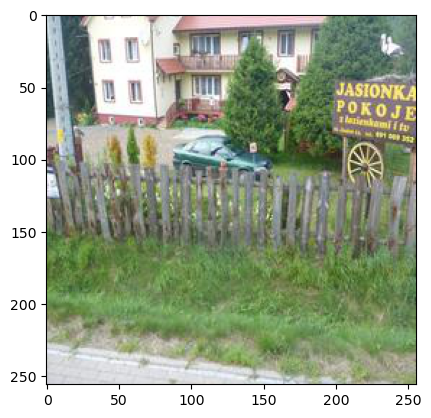

In [36]:
show_example(*aadb[0])
len(aadb)

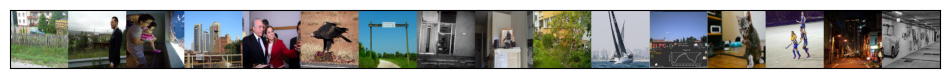

In [37]:


#train_ds, val_ds = random_split(aadb, [train_size, val_size])
#train_ds, val_ds = tf.data.Dataset.from_tensor_slices(aadb.files[:train_size]), tf.data.Dataset.from_tensor_slices(aadb.files[train_size:])
val_size = 500
train_size = len(aadb.files) - val_size

train_ds = tf.data.Dataset.from_generator(
    lambda: aadb,
    output_types=(tf.float32, tf.float32),
    output_shapes=((256, 256, 3), (12,))
).take(train_size)

val_ds = tf.data.Dataset.from_generator(
    lambda: aadb,
    output_types=(tf.float32, tf.float32),
    output_shapes=((256, 256, 3), (12,))
).skip(train_size)

train_ds = train_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

show_batch(train_ds)


In [38]:
class RankLoss(tf.Module):

    def __init__(self, margin):
        super().__init__()
        self.margin = margin

    def __call__(self, y_true, y_pred):
        # Calculate target
        target = tf.ones_like(y_true[0], dtype=y_pred[0].dtype)

        # Set indices where y_true1 < y_true2 to -1
        target = tf.where(y_true[0] < y_true[1], -1.0 * tf.ones_like(target), target)

        # Calculate margin ranking loss
        loss = tf.maximum(0.0, self.margin - (y_pred[0] - y_pred[1]) * target)
        return tf.reduce_mean(loss)




class RegRankLoss(tf.Module):

    def __init__(self, margin: float):
        super().__init__()
        self.reg_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
        self.rank_loss = RankLoss(margin)

    def __call__(self,
        y_pred: Tuple[tf.Tensor, tf.Tensor],
        y_true: Tuple[tf.Tensor, tf.Tensor]) -> Tuple[tf.Tensor, tf.Tensor]:
        
        loss_reg = (
            self.reg_loss(y_pred[0], y_true[0]) +
            self.reg_loss(y_pred[1], y_true[1])
        ) / 2.0

        loss_rank = self.rank_loss(y_pred, y_true)
        loss = loss_reg + loss_rank
        return loss, loss_reg, loss_rank
    
    

In [39]:

def create_backbone(backbone_name, pretrained):
    """
    Creates a backbone model from a pre-trained model.
    Args:
        backbone_name (str): Name of the backbone model (e.g., 'resnet50').
        pretrained (bool): Whether to use pre-trained weights.
    Returns:
        tf.keras.Model: The backbone model.
    """
    backbone = getattr(tf.keras.applications, backbone_name)(
        include_top=False,
        weights='imagenet' if pretrained else None,
        input_shape=(256, 256, 3)  # Replace with your input shape
    )
    
    return backbone

    
def create_regression_network(backbone, num_attributes):
    """
    Creates a regression network using the given backbone.
    Args:
        backbone (tf.keras.Model): The backbone model.
        num_attributes (int): Number of attributes for the regression task.
    Returns:
        tf.keras.Model: The regression network.
    """
    inputs = tf.keras.Input(shape=(256, 256, 3), batch_size=batch_size)
    x = backbone(inputs, training=False)
    #x = backbone.output

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_attributes, activation='linear')(x)
    model = tf.keras.Model(inputs, outputs)

    return model


In [40]:

#model = RegressionNetwork(backbone='ResNet50', num_attributes=len(attributes), pretrained=False)
backbone = create_backbone('MobileNetV2', pretrained=True)
backbone.trainable = True
num_layers = len(backbone.layers)
for layer in backbone.layers[:num_layers - 8]:
    layer.trainable = False
model = create_regression_network(backbone, 12)


In [41]:
loss_fn = RegRankLoss(margin=0.02)

In [42]:

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model, epoch=tf.Variable(0))
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

best = float('inf')
best_epoch = 0
patience = 3
wait = 0
train_losses = []
train_losses_reg = []
train_losses_rank = []
val_losses = []

@tf.function
def train_step(x_batch, y_batch):
    with tf.GradientTape() as tape:
        x1, x2 = tf.split(x_batch, 2, axis=0)
        y1, y2 = tf.split(y_batch, 2, axis=0)
        y_pred1 = model(x1, training=True)
        y_pred2 = model(x2, training=True)
        loss, loss_reg, loss_rank = loss_fn(y_pred=(y_pred1, y_pred2), y_true=(y1, y2))

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, loss_reg, loss_rank

@tf.function
def val_step(x_batch, y_batch):
    y_pred = model(x_batch, training=False)
    val_loss = tf.keras.losses.MeanSquaredError()(y_pred=y_pred, y_true=y_batch)
    return val_loss

try:
    checkpoint.restore(manager.latest_checkpoint)
    epoch = int(checkpoint.epoch)
    print("Restored from {}".format(manager.latest_checkpoint))
except Exception as e:
    print(f"Error restoring checkpoint: {e}")

for epoch in range(epochs):
    train_batch_count = 0
    for x_batch, y_batch in train_ds:
        loss, loss_reg, loss_rank = train_step(x_batch, y_batch)
        print(f"Epoch {epoch+1}/{epochs}, Batch {train_batch_count+1}, Reg Loss: {loss_reg:.4f}, Rank Loss: {loss_rank:.4f}", end="\r")
        train_losses.append(loss)
        train_losses_reg.append(loss_reg)
        train_losses_rank.append(loss_rank)
        train_batch_count += 1

    val_loss = 0.0
    val_batch_count = 0
    for x_batch, y_batch in val_ds:
        val_loss += val_step(x_batch, y_batch)
        val_batch_count += 1
    val_loss /= val_batch_count
    val_losses.append(val_loss)

    wait += 1
    if val_loss < best:
        best = val_loss
        best_epoch = epoch
        wait = 0
    if wait > patience:
        print(f"\nEarly stopping at epoch {epoch}.")
        break

    print(f"\nEpoch {epoch+1}/{epochs}, Val Loss: {val_loss:.4f}")
    manager.save()

    checkpoint.save(file_prefix=checkpoint_prefix)
    print(f"\nSaved checkpoint for epoch {epoch}.")

Restored from None
Epoch 1/5, Batch 529, Reg Loss: 0.0425, Rank Loss: 0.0590
Epoch 1/5, Val Loss: 0.0872

Saved checkpoint for epoch 0.
Epoch 2/5, Batch 529, Reg Loss: 0.0424, Rank Loss: 0.0553
Epoch 2/5, Val Loss: 0.0817

Saved checkpoint for epoch 1.
Epoch 3/5, Batch 529, Reg Loss: 0.0429, Rank Loss: 0.0693
Epoch 3/5, Val Loss: 0.0790

Saved checkpoint for epoch 2.
Epoch 4/5, Batch 529, Reg Loss: 0.0432, Rank Loss: 0.0657
Epoch 4/5, Val Loss: 0.0773

Saved checkpoint for epoch 3.
Epoch 5/5, Batch 529, Reg Loss: 0.0432, Rank Loss: 0.0693
Epoch 5/5, Val Loss: 0.0760

Saved checkpoint for epoch 4.


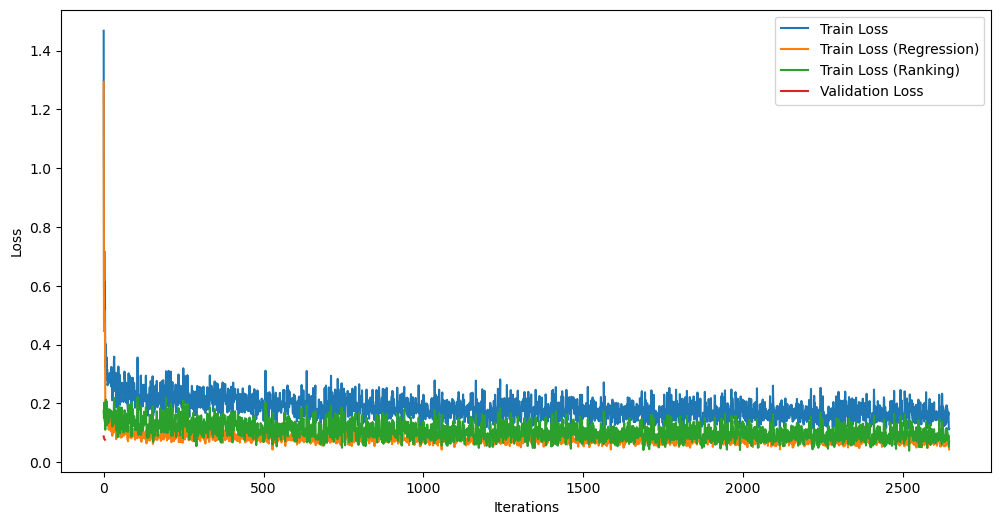

In [43]:
# plot losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(train_losses_reg, label='Train Loss (Regression)')
plt.plot(train_losses_rank, label='Train Loss (Ranking)')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()



INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


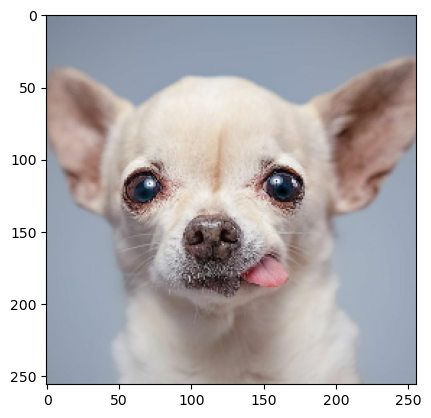

Prediction: {'balancing_elements': 0.007821158, 'color_harmony': 0.38445142, 'content': 0.6877289, 'depth_of_field': 0.3983785, 'light': 0.16183528, 'motion_blur': -0.009497735, 'object': 0.7254149, 'repetition': 0.03404613, 'rule_of_thirds': 0.10018231, 'symmetry': 0.16209608, 'vivid_color': 0.6485735, 'score': -0.028921928}


In [44]:
model.save("model.keras")
# save to h5
#model.save("model.h5")
# save to saved model
tf.saved_model.save(model, "model")

attributes = [
    "balancing_elements",
    "color_harmony",
    "content",
    "depth_of_field",
    "light",
    "motion_blur",
    "object",
    "repetition",
    "rule_of_thirds",
    "symmetry",
    "vivid_color",
    "score",
]

def show_prediction_custom(image_path):
    image = Image.open(image_path).convert('RGB')
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32) / 127.5 - 1
    image = tf.expand_dims(image, axis=0)
    
    model_path = 'model.keras'
    model = tf.keras.models.load_model(model_path)
    prediction = model(image)
    prediction = {attributes[i]: prediction[0][i].numpy() for i in range(len(attributes))}
    plt.imshow(image[0] * 0.5 + 0.5)
    plt.show()
    print(f'Prediction: {prediction}')


show_prediction_custom('/mnt/c/Users/austi/Downloads/input.jpg')



In [45]:
# create tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Load TFLite model and allocate tensors.

INFO:tensorflow:Assets written to: /tmp/tmp109tgwhv/assets


INFO:tensorflow:Assets written to: /tmp/tmp109tgwhv/assets
2024-04-21 19:23:32.657573: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-21 19:23:32.657666: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-21 19:23:32.659056: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp109tgwhv
2024-04-21 19:23:32.672194: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-21 19:23:32.672235: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp109tgwhv
2024-04-21 19:23:32.701260: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-04-21 19:23:32.718436: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-04-21 19:23:33.145938: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

In [46]:
model.output_shape

(16, 12)